In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from properscoring import crps_ensemble
import random


sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, plot_pnn_preds, plot_prop_pnn_preds
D = 40
M = 50
T = 10

start_year = 2013
end_year = 2023
data_split = [0.7, 0.15, 0.15]
seed = 123

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [2]:
# Create serotype obj
denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period('M')
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period('M')
sero_props['Collection date'] = pd.to_datetime(sero_props['Collection date']).dt.to_period('M')
sero_dataset = SeroDataset(dataset=denv_df, prop_dataset=sero_props, T=T)

In [3]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)


In [4]:
# End of 2023 appears to have some incomplete data

dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


In [5]:
class PNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        y = self.true_count_obj.get_y(date)
        dow = date.day_of_week
        return (obs, dow), y

set_seed(seed)
train_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_pnn_dataset, batch_size=32, shuffle=False)


In [6]:
pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
pnn_train = BaseTrain("PNN")
pnn_train.train_model(pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 7.97e+04 - Val loss: 1.5e+06 - ES count: 0
Epoch 2 - Train loss: 6.11e+04 - Val loss: 9.77e+05 - ES count: 0
Epoch 3 - Train loss: 5.3e+04 - Val loss: 9.01e+05 - ES count: 0
Epoch 4 - Train loss: 4.78e+04 - Val loss: 5.65e+05 - ES count: 0
Epoch 5 - Train loss: 4.09e+04 - Val loss: 6.94e+05 - ES count: 1
Epoch 6 - Train loss: 3.46e+04 - Val loss: 4.27e+05 - ES count: 0
Epoch 7 - Train loss: 2.97e+04 - Val loss: 6.19e+05 - ES count: 1
Epoch 8 - Train loss: 2.38e+04 - Val loss: 3.51e+05 - ES count: 0
Epoch 9 - Train loss: 1.96e+04 - Val loss: 3.36e+05 - ES count: 0
Epoch 10 - Train loss: 1.64e+04 - Val loss: 1.71e+05 - ES count: 0
Epoch 11 - Train loss: 1.33e+04 - Val loss: 1.61e+05 - ES count: 0
Epoch 12 - Train loss: 1.13e+04 - Val loss: 8.34e+04 - ES count: 0
Epoch 13 - Train loss: 9.85e+03 - Val loss: 9.08e+04 - ES count: 1
Epoch 14 - Train loss: 8.29e+03 - Val loss: 8.07e+04 - ES count: 0
Epoch 15 - Train loss: 7.52e+03 - Val loss: 6.85e+04 - ES count: 0
Epoch 

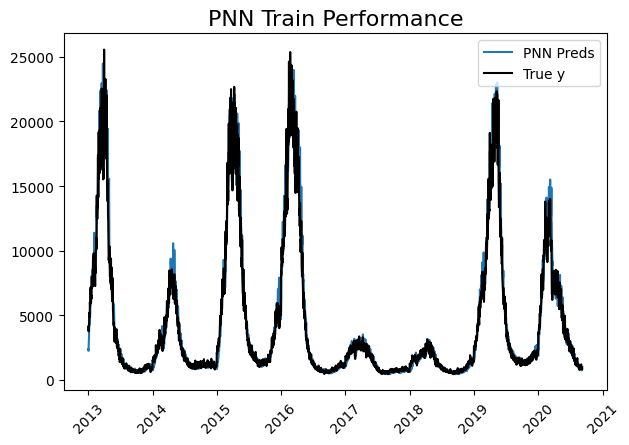

CRPS: 338.1682455290345


In [7]:
pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PNN"))

pnn_train_samples, train_y_true = eval_pnn(train_pnn_dataset, pnn_model)


plot_pnn_preds(pnn_train_samples,train_pnn_dataset, "PNN Train Performance")
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), pnn_train_samples).mean()}")

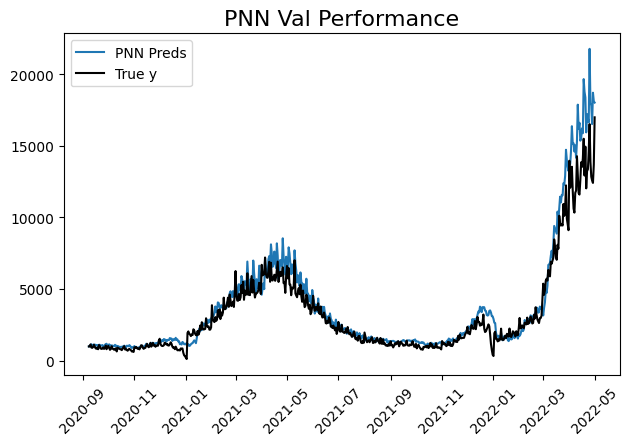

CRPS: 467.3605750415972


In [8]:
pnn_val_samples, val_y_true = eval_pnn(val_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_val_samples,val_pnn_dataset, "PNN Val Performance")
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), pnn_val_samples).mean()}")

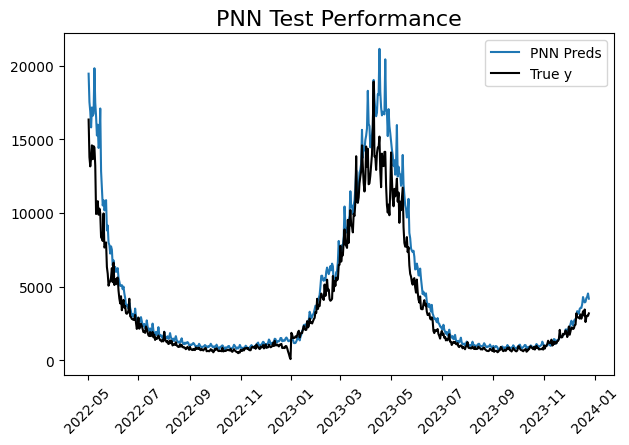

CRPS: 611.3139582089551


In [9]:
pnn_test_samples, test_y_true = eval_pnn(test_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_test_samples,test_pnn_dataset, "PNN Test Performance")
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), pnn_test_samples).mean()}")

In [10]:
class PropPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        z = self.true_count_obj.get_z(date)
        dow = date.day_of_week
        return (obs, dow), z

set_seed(seed)
train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [11]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_train = BaseTrain("PropPNN")
prop_pnn_train.train_model(prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 7.97e+03 - Val loss: 1.06e+05 - ES count: 0
Epoch 2 - Train loss: 4.73e+03 - Val loss: 7.83e+04 - ES count: 0
Epoch 3 - Train loss: 4.11e+03 - Val loss: 5.94e+04 - ES count: 0
Epoch 4 - Train loss: 3.5e+03 - Val loss: 4.98e+04 - ES count: 0
Epoch 5 - Train loss: 3.07e+03 - Val loss: 3.7e+04 - ES count: 0
Epoch 6 - Train loss: 2.61e+03 - Val loss: 3.63e+04 - ES count: 0
Epoch 7 - Train loss: 2.37e+03 - Val loss: 2.84e+04 - ES count: 0
Epoch 8 - Train loss: 2.06e+03 - Val loss: 2.83e+04 - ES count: 0
Epoch 9 - Train loss: 2.05e+03 - Val loss: 2.26e+04 - ES count: 0
Epoch 10 - Train loss: 1.84e+03 - Val loss: 2.14e+04 - ES count: 0
Epoch 11 - Train loss: 1.75e+03 - Val loss: 1.83e+04 - ES count: 0
Epoch 12 - Train loss: 1.69e+03 - Val loss: 1.31e+04 - ES count: 0
Epoch 13 - Train loss: 1.56e+03 - Val loss: 1.49e+04 - ES count: 1
Epoch 14 - Train loss: 1.61e+03 - Val loss: 1.32e+04 - ES count: 2
Epoch 15 - Train loss: 1.46e+03 - Val loss: 1.22e+04 - ES count: 0
Epoch 

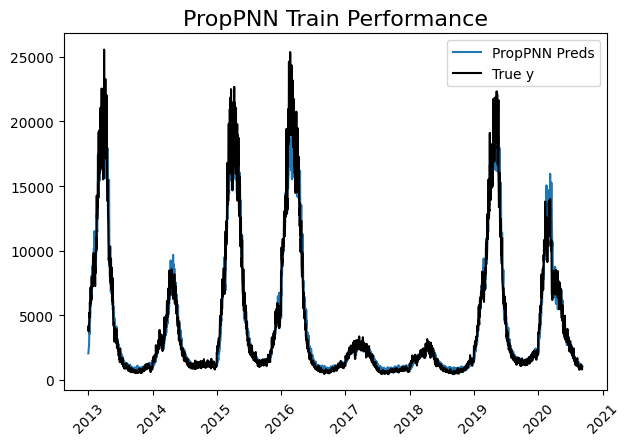

CRPS: 415.5903714998219


In [12]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PropPNN"))

prop_pnn_train_samples, train_z_true = eval_prop_pnn(train_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_train_samples,train_prop_pnn_dataset, "PropPNN Train Performance")

train_y_true = train_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), prop_pnn_train_samples).mean()}")

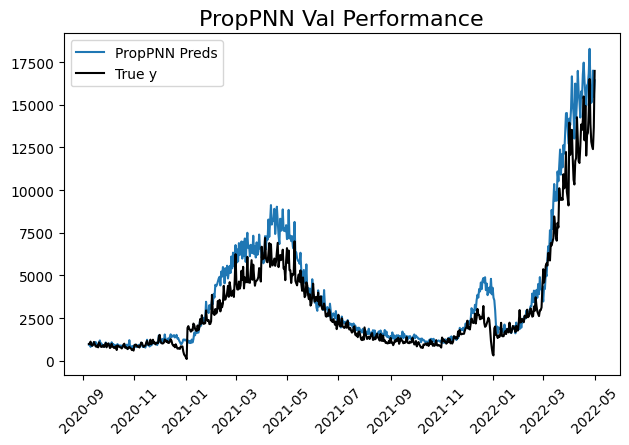

CRPS: 560.4195866888517


In [13]:
prop_pnn_val_samples, val_z_true = eval_prop_pnn(val_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_val_samples,val_prop_pnn_dataset, "PropPNN Val Performance")

val_y_true = val_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), prop_pnn_val_samples).mean()}")

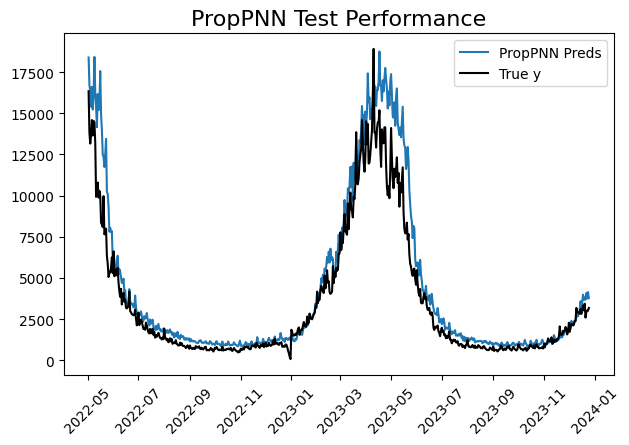

CRPS: 665.1891303482586


In [14]:
prop_pnn_test_samples, test_z_true = eval_prop_pnn(test_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_test_samples,test_prop_pnn_dataset, "PropPNN Test Performance")

test_y_true = test_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), prop_pnn_test_samples).mean()}")

In [15]:
set_seed(seed)
train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [16]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_train = SparsePropTrain("SparsePropPNN")
sparse_prop_pnn_train.train_model(sparse_prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 2.15e+05 - Val loss: 2.36e+06 - ES count: 0
Epoch 2 - Train loss: 1.26e+05 - Val loss: 2.34e+06 - ES count: 0
Epoch 3 - Train loss: 1.1e+05 - Val loss: 1.64e+06 - ES count: 0
Epoch 4 - Train loss: 9.81e+04 - Val loss: 1.64e+06 - ES count: 1
Epoch 5 - Train loss: 8.93e+04 - Val loss: 1.43e+06 - ES count: 0
Epoch 6 - Train loss: 8.15e+04 - Val loss: 1.2e+06 - ES count: 0
Epoch 7 - Train loss: 9.02e+04 - Val loss: 1.51e+06 - ES count: 1
Epoch 8 - Train loss: 8.52e+04 - Val loss: 1.35e+06 - ES count: 2
Epoch 9 - Train loss: 6.56e+04 - Val loss: 1.28e+06 - ES count: 3
Epoch 10 - Train loss: 6.76e+04 - Val loss: 9.26e+05 - ES count: 0
Epoch 11 - Train loss: 5.67e+04 - Val loss: 6.8e+05 - ES count: 0
Epoch 12 - Train loss: 5.21e+04 - Val loss: 7.13e+05 - ES count: 1
Epoch 13 - Train loss: 5.06e+04 - Val loss: 6.36e+05 - ES count: 0
Epoch 14 - Train loss: 5.52e+04 - Val loss: 7.5e+05 - ES count: 1
Epoch 15 - Train loss: 4.62e+04 - Val loss: 7.94e+05 - ES count: 2
Epoch 16

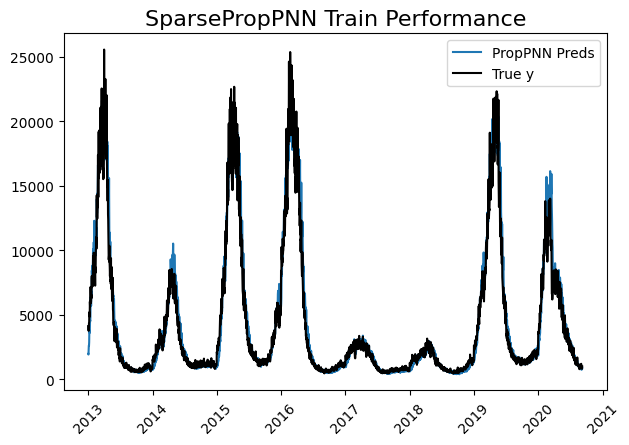

CRPS: 436.7815813323834


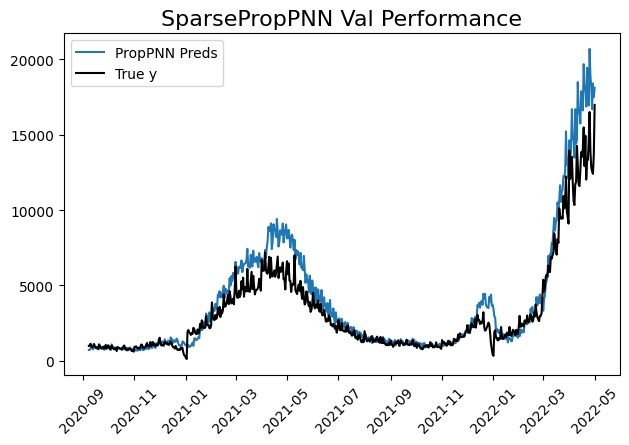

CRPS: 619.3857391014974


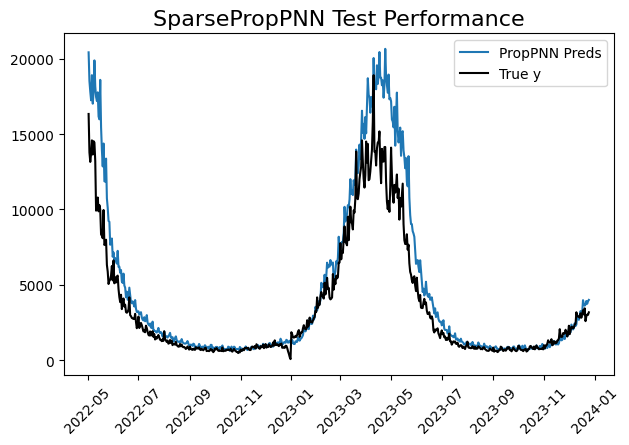

CRPS: 822.3796723051407


In [17]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SparsePropPNN"))

sparse_prop_pnn_train_samples, train_z_true = eval_sparse_prop_pnn(train_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_train_samples,train_prop_pnn_dataset, "SparsePropPNN Train Performance")

train_y_true = train_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), sparse_prop_pnn_train_samples).mean()}")

sparse_prop_pnn_val_samples, val_z_true = eval_sparse_prop_pnn(val_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_val_samples,val_prop_pnn_dataset, "SparsePropPNN Val Performance")

val_y_true = val_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), sparse_prop_pnn_val_samples).mean()}")

sparse_prop_pnn_test_samples, test_z_true = eval_sparse_prop_pnn(test_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_test_samples,test_prop_pnn_dataset, "SparsePropPNN Test Performance")

test_y_true = test_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), sparse_prop_pnn_test_samples).mean()}")